**Audio + Visual Summary**

The Audio + Visual summary is generated by sending the model both the visual and the audio from the video at once. When sending both of these, the model is expected to better summarize since it can perceive the entire video at once.

In [ ]:
!pip install --upgrade openai --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00


In [ ]:
!pip install opencv-python --quiet

In [ ]:
!pip install moviepy --quiet

In [ ]:
from google.colab import userdata
OPEN_AI_KEY=userdata.get('opeaikey4o')

In [ ]:
from openai import OpenAI


## Set the API key and model name
MODEL="gpt-4o"
client = OpenAI(api_key=OPEN_AI_KEY)

In [ ]:
import cv2
from moviepy.editor import VideoFileClip
import time
import base64

# We'll be using the OpenAI DevDay Keynote Recap video. You can review the video here: https://www.youtube.com/watch?v=h02ti0Bl6zk
VIDEO_PATH = "chatgpt_brief_intro.mp4"


In [ ]:
def process_video(video_path, seconds_per_frame=1,base_video_path="chatgpt_brief_intro"):
    base64Frames = []

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame=0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    # Extract audio from video
    audio_path = f"{base_video_path}.mp3"
    clip = VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_path, bitrate="32k")
    clip.audio.close()
    clip.close()

    print(f"Extracted {len(base64Frames)} frames")
    print(f"Extracted audio to {audio_path}")
    return base64Frames, audio_path




In [ ]:
# Extract 1 frame per second. You can adjust the `seconds_per_frame` parameter to change the sampling rate
base64Frames, audio_path = process_video(VIDEO_PATH, seconds_per_frame=1)

MoviePy - Writing audio in chatgpt_brief_intro.mp3


MoviePy - Done.
Extracted 38 frames
Extracted audio to chatgpt_brief_intro.mp3


In [ ]:
from IPython.display import Image, display, Audio, Markdown
import base64


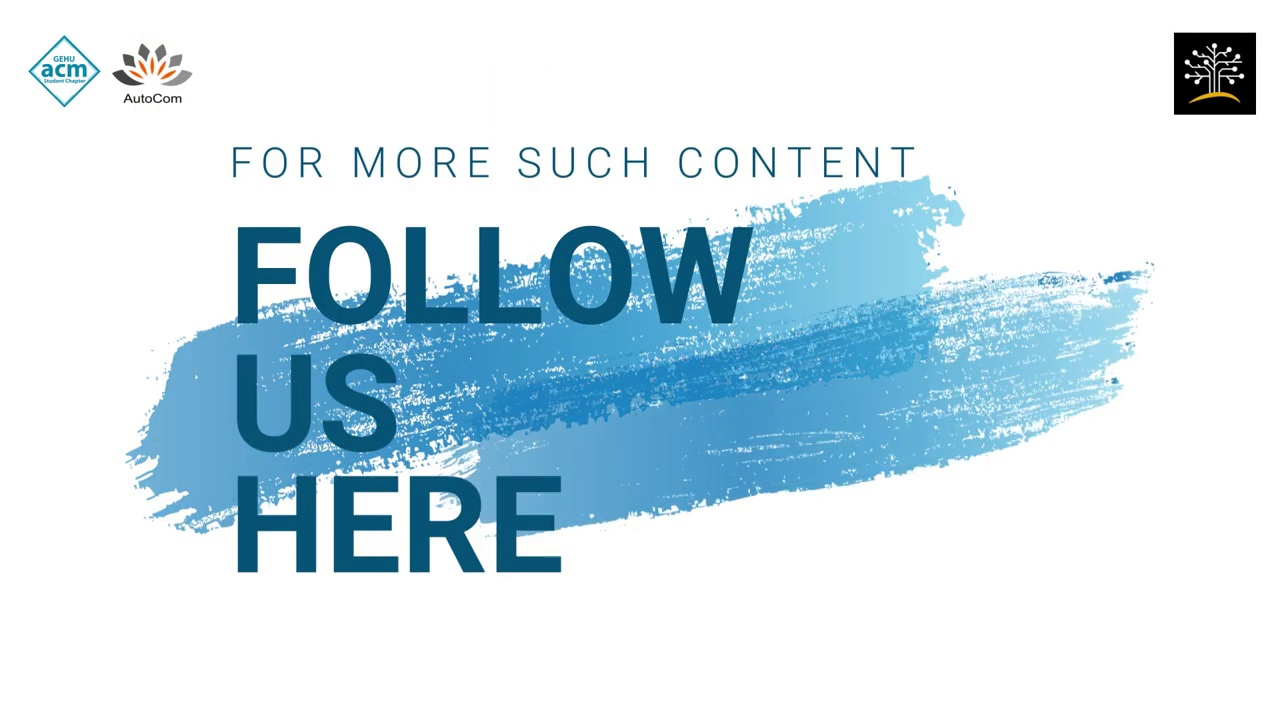

In [ ]:
## Display the frames and audio for context
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(0.025)

Audio(audio_path)

In [ ]:
audio_path="chatgpt_brief_intro.mp3"

In [ ]:
# Transcribe the audio
transcription = client.audio.transcriptions.create(
    model="whisper-1",
    file=open(audio_path, "rb"),
)
## OPTIONAL: Uncomment the line below to print the transcription
#print("Transcript: ", transcription.text + "\n\n")

response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""You are generating a transcript summary. Create a summary of the provided transcription. Respond in Markdown."""},
    {"role": "user", "content": [
        {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
    }
    ],
    temperature=0,
)
print(response.choices[0].message.content)

## Summary

In today's discussion, the focus is on ChatGPT, an AI-backed chatbot prototype developed by OpenAI. ChatGPT answers user queries conversationally, can write review codes, and solve math problems. It utilizes a neural network architecture and unsupervised learning to generate responses, allowing it to learn and respond without explicit instructions, making it a versatile tool for various conversational tasks.


In [ ]:
## Generate a summary with visual and audio
response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {"role": "system", "content":"""You are generating a video summary. Create a summary of the provided video and its transcript. Respond in Markdown"""},
    {"role": "user", "content": [
        "These are the frames from the video.",
        *map(lambda x: {"type": "image_url",
                        "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames),
        {"type": "text", "text": f"The audio transcription is: {transcription.text}"}
        ],
    }
],
    temperature=0,
)
print(response.choices[0].message.content)

## Video Summary

The video provides an overview of ChatGPT, an AI-backed chatbot developed by OpenAI. It explains what ChatGPT is and how it works, highlighting its capabilities and underlying technology.

### Key Points:
1. **Introduction to ChatGPT**:
   - The video begins with a retro-style note window displaying the text "CHAT GPT" and then transitions to the question "WHAT IS CHATGPT?".

2. **Search and Information**:
   - A search for "ChatGPT" is shown, leading to the OpenAI website, which provides information about optimizing language models for dialogue.

3. **Functionality**:
   - The video demonstrates ChatGPT's ability to interact conversationally, showing a user typing "Hi, how are you?" and ChatGPT responding with "Hello! I'm just a computer program, so I don't have feelings or physical sensations. Is there something specific you would like to know or talk about?"

4. **Technology Behind ChatGPT**:
   - The video explains that ChatGPT uses a neural network architecture a

After combining both the video and audio, we're able to get a much more detailed and comprehensive summary for the event which uses information from both the visual and audio elements from the video.